# cp_wopt demo

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pprint import pprint
import itertools

import cp
import base

from mpl_toolkits import mplot3d
import matplotlib.cm as cm

# Aminoacid dataset

## Load data

In [2]:
X = loadmat('datasets/aminoacids.mat')['X'][0][0]['data']
X = X/np.linalg.norm(X)

## Create a mask 
The mask removes about 50% of the values randomly

Text(0.5,0.98,'Mask')

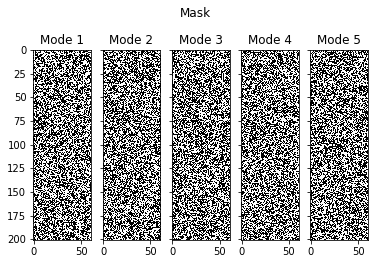

In [3]:
W = np.round(np.random.random(X.shape)).astype(np.int)

fig, axes = plt.subplots(1, 5, sharey=True, sharex=True)

# Let's display the mask
for i, ax in enumerate(axes):
    ax.imshow(W[i,...], cmap='gray')
    ax.set_title(f'Mode {i+1}')
    
fig.suptitle("Mask")

## We create a masked array

In [5]:
X_masked = np.ma.MaskedArray(X.copy(), mask=(W==0), fill_value=-10) # fill_value cannot be nan
# MATLAB cp_wopt assumes that missing entries of X have been sent to zero. Why zero?

In [6]:
# To make the masked values transparent while plotting:
colormap = cm.viridis
colormap.set_under('k', alpha=0)

## Plot the masked data

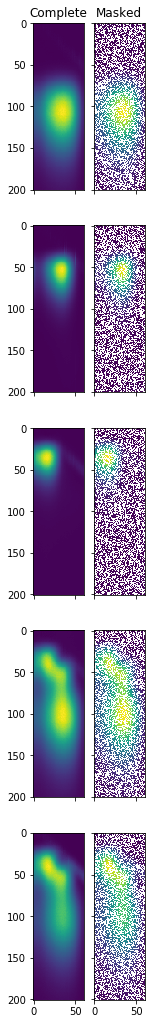

In [7]:
fig, axes = plt.subplots(5, 2, sharey=True, sharex=True, figsize=(2,18))

axes[0][0].set_title('Complete')
axes[0][1].set_title('Masked')
    
for i, ax in enumerate(axes):
    ax[0].imshow(X[i,...])
    ax[1].imshow(X_masked[i,...],cmap=colormap, vmin=np.min(X))

## Find parafac decomposition of masked values with cp_wopt

In [8]:
factors, result, initial_factors, log = cp.cp_wopt(X_masked, W=W, rank=3, method='l-bfgs-b', init='random', gtol=1e-5)
print(result.message)
print(f'F(x): {result.fun}')
print(f'Number of iterations: {result.nit}')
print(f'Number of function evaluations: {result.nfev}')

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
F(x): 0.00015542032110976624
Number of iterations: 92
Number of function evaluations: 104


## Compare with decomposition from complete tensor

In [16]:
complete_factors, result, initial_factors, log = cp.cp_opt(X,rank=3, method='cg', init='random', gtol=1e-5)
fms, best_permutation = cp.factor_match_score(factors, complete_factors)

print(f'Factor match score: {fms}, best permutation: {best_permutation}')

Factor match score: 0.9998105909784119, best permutation: (0, 2, 1)


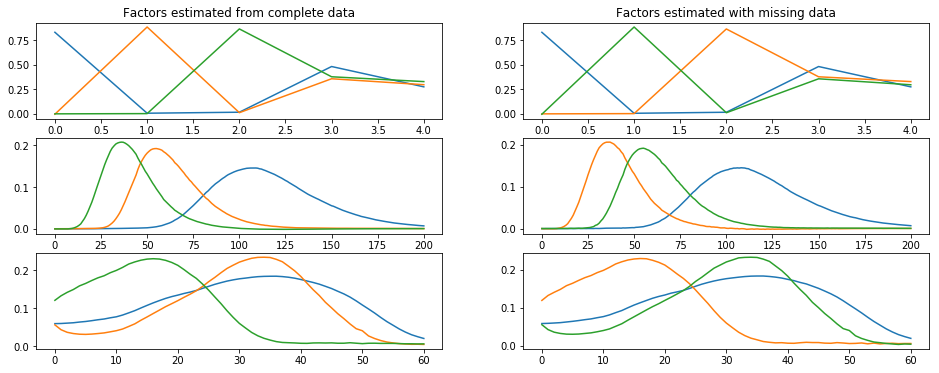

In [19]:
f1, s1, n1 = cp.prepare_for_comparison(complete_factors)
f2, s2, n2 = cp.prepare_for_comparison(factors)

fig, axes = plt.subplots(len(f1), 2, figsize=(16, 6))
for i in range(len(factors)):
    axes[i][0].plot(f1[i], '-')
    axes[0][0].set_title('Factors estimated from complete data')
    
    axes[i][1].plot(f2[i], '-')
    axes[0][1].set_title('Factors estimated with missing data')

plt.show()

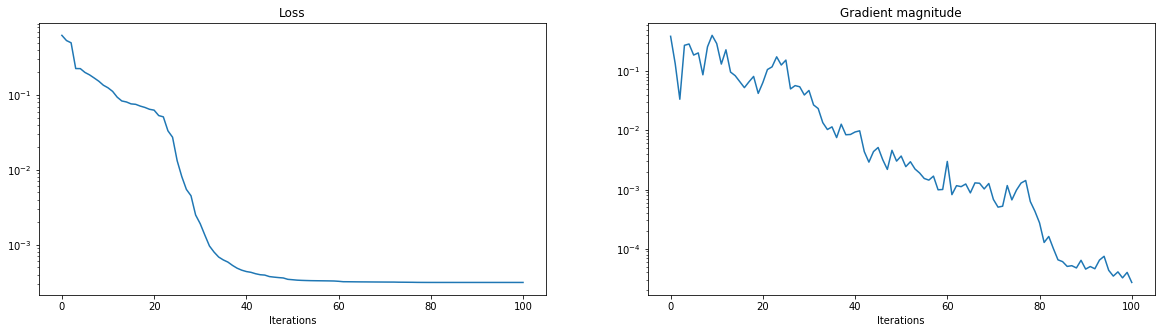

In [20]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(log.loss_values)
ax1.set_title('Loss')
ax1.set_xlabel('Iterations')

ax1.set_yscale('log')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(log.gradient_values)
ax2.set_title('Gradient magnitude')
ax2.set_xlabel('Iterations')

ax2.set_yscale('log')

plt.show()

# Reconstruct the data from the factors

In [21]:
X_hat = base.ktensor(*tuple(factors))
X_hat.shape

(5, 201, 61)

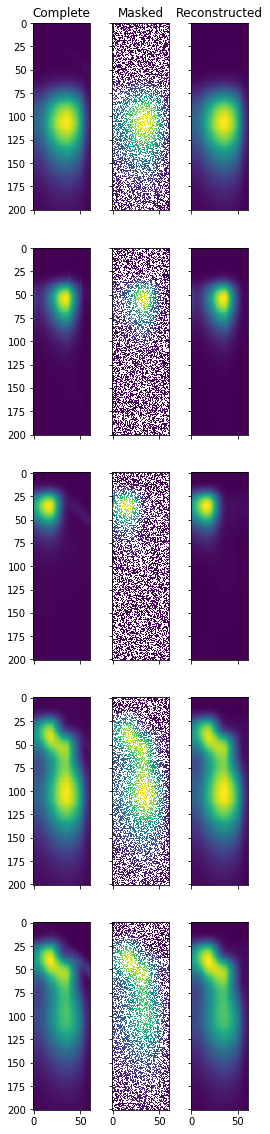

In [22]:
fig, axes = plt.subplots(5, 3, sharey=True, sharex=True, figsize=(4,20))

axes[0][0].set_title(f'Complete')
axes[0][1].set_title(f'Masked')
axes[0][2].set_title(f'Reconstructed')
for i, ax in enumerate(axes):
    ax[0].imshow(X[i,...])
    ax[1].imshow(X_masked[i,...],cmap=colormap, vmin=np.min(X))
    ax[2].imshow(X_hat[i,...])

## Plot estimated vs true values for the missing data

Text(0.5,1,'Estimated missing values')

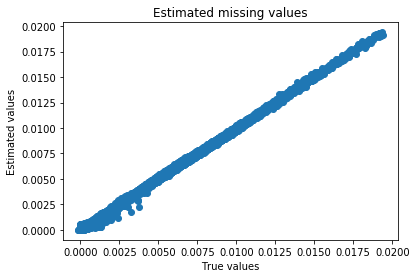

In [23]:
plt.plot(X[W==0], X_hat[W==0], 'o')
plt.xlabel("True values")
plt.ylabel("Estimated values")
plt.title("Estimated missing values")

## Surface plots

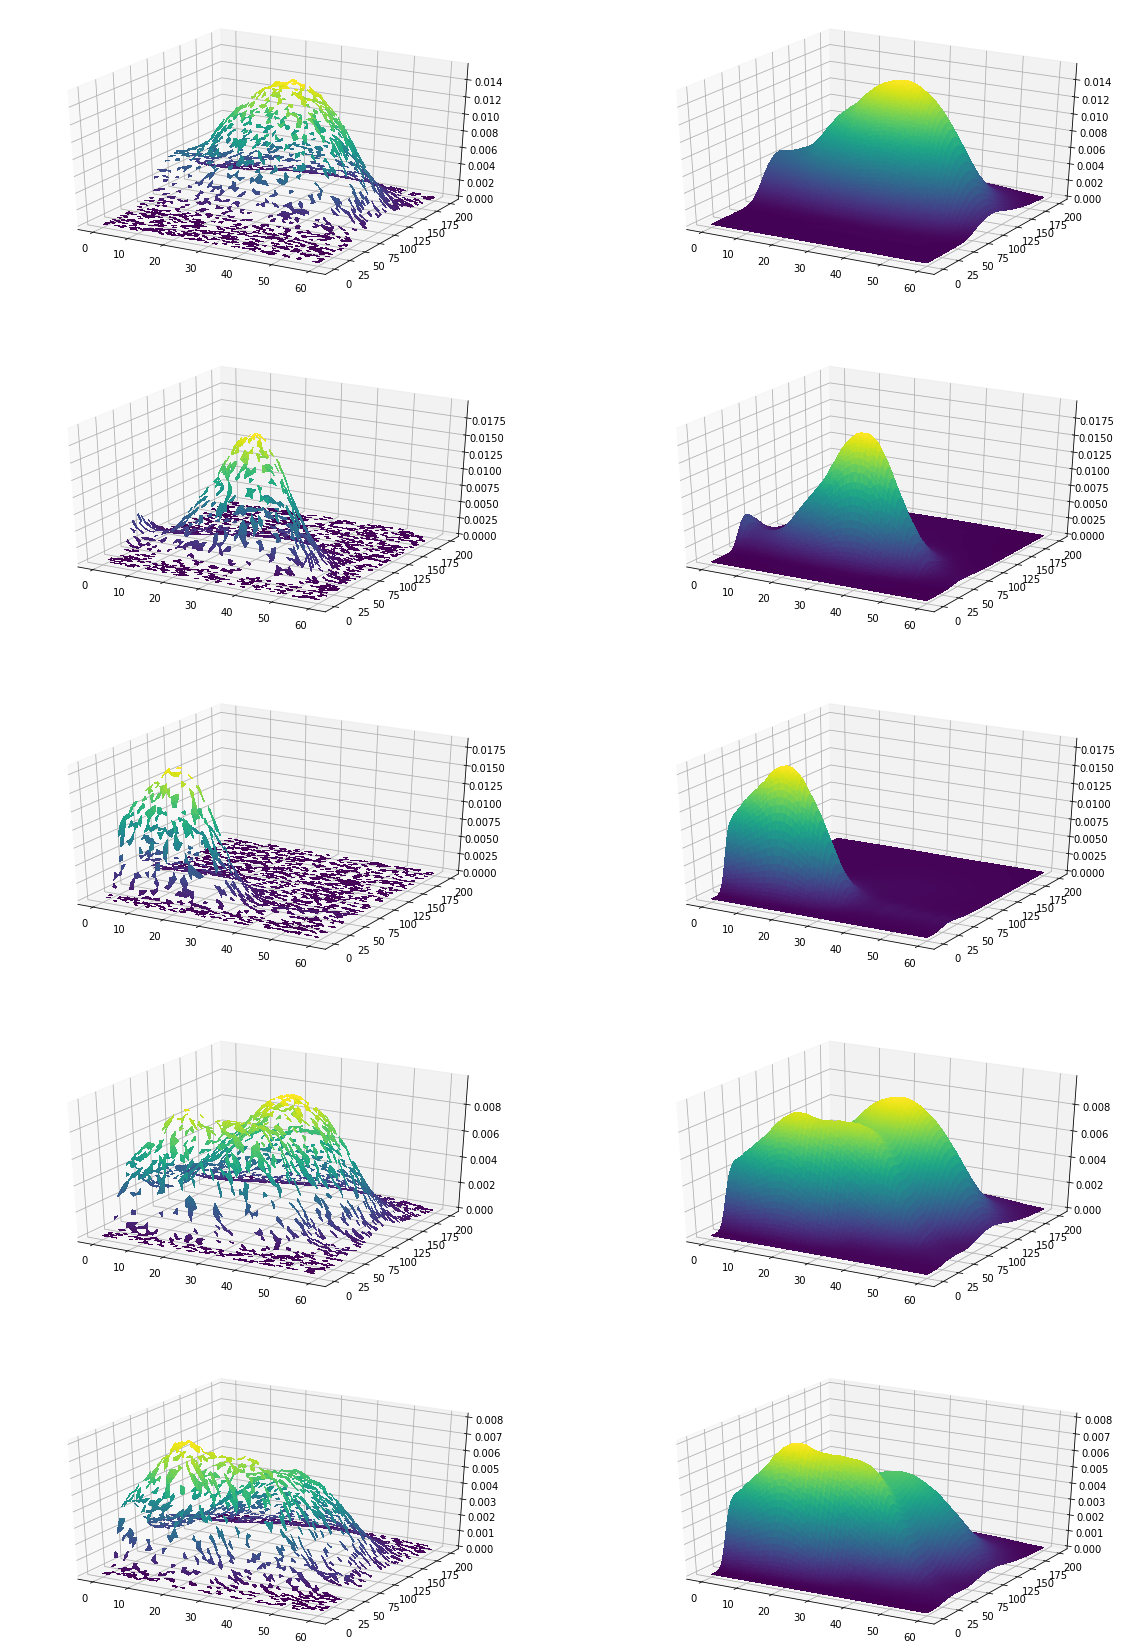

In [24]:
x = range(X.shape[1])
y = range(X.shape[2])
X_mesh, Y_mesh = np.meshgrid(y, x)

fig = plt.figure(figsize=(20,30))

for i in range(X.shape[0]):
    mask = W[i]
    
    Z_masked = X_masked[i].copy()
    Z_masked[mask==0] = -10 # tri_surf does not support masked array?
    
    ax1 = fig.add_subplot(5, 2, 2*i+1, projection='3d')
    ax1.plot_trisurf(X_mesh.ravel(), Y_mesh.ravel(), Z_masked.ravel(), vmin=np.min(X[i]), linewidth=0, antialiased=False, cmap=colormap)
    ax1.set_zlim([np.min(X[i]), np.max(X[i])])

    ax2 = fig.add_subplot(5, 2, 2*i+2, projection='3d')
    ax2.plot_trisurf(X_mesh.ravel(), Y_mesh.ravel(), X_hat[i].ravel(), vmin=np.min(X[i]), linewidth=0, antialiased=False, cmap=colormap)
    ax2.set_zlim([np.min(X[i]), np.max(X[i])])
